In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib import colors as mcolors
from scgenome import cncluster
from scdna_replication_tools.plot_utils import get_clone_cmap, get_metacohort_cmaps, plot_cell_cn_profile2, get_htert_cmap, get_signals_cmap, plot_clustered_cell_cn_matrix, plot_colorbar

In [7]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

despine_offset = 10
despine_trim = True

### Load, preprocess, and plot data showing the clone and sample RT profiles for chrX vs chr1 in hTERT cell lines

In [8]:
# load the cell counts in each clone
counts = pd.read_csv('scdna_replication_paper/analysis/sig_lines/cohort_clone_counts.tsv', sep='\t')

datasets = ['SA039', 'SA906a', 'SA906b', 'SA1292', 'SA1056', 'SA1188', 'SA1054', 'SA1055', 'OV2295']

# read in the pseudobulk RT profiles for each sample
rt = pd.DataFrame()
for d in datasets:
    temp_path = 'scdna_replication_paper/analysis/sig_lines/{}/scRT_pseudobulks.tsv'.format(d)
    temp_rt = pd.read_csv(temp_path, sep='\t')
    cols = [c for c in temp_rt.columns if c.startswith('pseudobulk') and c.endswith('model_rep_state')]
    cols.append('chr')
    cols.append('start')
    temp_rt = temp_rt[cols]
    
    # add dataset name as prefix to RT columns
    for c in temp_rt.columns:
        if c.startswith('pseudobulk') and c.endswith('model_rep_state'):
            temp_rt.rename(columns={c: '{}_{}'.format(d, c)}, inplace=True)
    
    if rt.empty:
        rt = temp_rt
    else:
        rt = pd.merge(rt, temp_rt)

# set chr column to category
rt.chr = rt.chr.astype('str')
rt.chr = rt.chr.astype('category')

# add end position as it's necessary for plotting functions
rt['end'] = rt['start'] + 500000 - 1

# columns of interest for sample RT profiles
rt_coi = [c for c in rt.columns if (c.endswith('_pseudobulk_model_rep_state'))]

In [57]:
def plot_sample_rt_profiles(rt, rt_coi, counts, ax0, ax1, chrom_labels_to_remove):
    htert_cmap = get_htert_cmap()

    for i, col in enumerate(rt_coi):
        dataset_id = col.split('_')[0]

        # find the number of S-phase cells in this dataset according to counts
        n = int(np.sum(counts.query('dataset=="{}"'.format(dataset_id))['num_cells_s'].values))
        label = '{} (n={})'.format(dataset_id, n)
        
        # plot pseudobulk rt profile for this dataset
        plot_cell_cn_profile2(
            ax0, rt, col, color=htert_cmap[dataset_id], rawy=True, chromosome='1',
            max_cn=None, scale_data=False, lines=True, label=label, s=1, rasterized=True,
            chrom_labels_to_remove=chrom_labels_to_remove
        )
        # zoom in on chrX
        plot_cell_cn_profile2(
            ax1, rt, col, color=htert_cmap[dataset_id], rawy=True, chromosome='X',
            max_cn=None, scale_data=False, lines=True, label=label, s=1, rasterized=True,
            chrom_labels_to_remove=chrom_labels_to_remove
        )

    ax0.set_title('Sample pseudobulk RT')
    ax0.set_ylabel('RT\n<--late | early-->')
    ax1.set_ylabel('RT\n<--late | early-->')
    # set legend for ax1 to be underneath the x-axis with no border and 3 columns
    ax1.legend(title='', bbox_to_anchor=(0, -0.45, 1, 0), ncol=3, borderaxespad=0, frameon=False)


def plot_clone_rt_profiles(rt, dataset_id, counts, ax0, ax1, chrom_labels_to_remove):
    # get the clone RT columns for this dataset
    clone_rt_cols = [c for c in rt.columns if c.startswith(dataset_id) and 'clone' in c]

    clone_cmap = get_clone_cmap()

    # plot each clone RT profile as a different color
    # only plot the X chromosome for now
    for i, col in enumerate(clone_rt_cols):
        clone_id = col.split('_')[2].split('clone')[1]
        # find the number of S-phase cells in this clone according to dataset_counts
        n = int(counts.query("dataset=='{}'".format(dataset_id)).query("clone_id=='{}'".format(clone_id))['num_cells_s'].values[0])
        label = '{} (n={})'.format(clone_id, n)
        
        # plot pseudobulk rt profile for this clone for chr1
        plot_cell_cn_profile2(
            ax0, rt, col, color=clone_cmap[clone_id], rawy=True, chromosome='1',
            max_cn=None, scale_data=False, lines=True, label=label, s=1, rasterized=True,
            chrom_labels_to_remove=chrom_labels_to_remove
        )
        # zoom in on chrX
        plot_cell_cn_profile2(
            ax1, rt, col, color=clone_cmap[clone_id], rawy=True, chromosome='X',
            max_cn=None, scale_data=False, lines=True, label=label, s=1, rasterized=True,
            chrom_labels_to_remove=chrom_labels_to_remove
        )
    
    ax0.set_title('{} clone pseudobulk RT'.format(dataset_id))
    ax0.set_ylabel('RT\n<--late | early-->')
    ax1.set_ylabel('RT\n<--late | early-->')
    # set legend for ax1 to be underneath the x-axis with no border and 3 columns
    ax1.legend(title='', bbox_to_anchor=(0, -0.45, 1, 0), ncol=3, borderaxespad=0, frameon=False, mode='expand')


### Load data and create plots to show that chrX RT correlates with DNA BAF at clone resolution

In [13]:
# load BAFs, RT delays, and counts
sample_bafs = pd.read_csv('scdna_replication_paper/analysis/chrX/sample_arm_bafs.csv.gz')
clone_bafs = pd.read_csv('scdna_replication_paper/analysis/chrX/clone_arm_bafs.csv.gz')
sample_mean_rt = pd.read_csv('scdna_replication_paper/analysis/chrX/sample_rt.csv.gz')
clone_mean_rt = pd.read_csv('scdna_replication_paper/analysis/chrX/clone_rt.csv.gz')
counts = pd.read_csv('scdna_replication_paper/analysis/chrX/counts.csv.gz')
counts.head()

,clone_id,num_cells_s,num_cells_g,dataset,frac_cells_s,frac_cells_g
0,A,663.0,1159.0,SA039,0.488578,0.794925
1,B,453.0,165.0,SA039,0.333825,0.113169
2,C,209.0,129.0,SA039,0.154016,0.088477
3,D,32.0,5.0,SA039,0.023581,0.003429
4,A,103.0,47.0,SA906a,0.075292,0.064384


In [14]:
def merge_sample_rt_and_bafs(sample_mean_rt, sample_bafs):
    ''' Query and pivot the dataframes such that each row has both the chrX RT delay and BAFs for a given sample '''
    # subset df to just chr=='X'
    sample_df = sample_bafs.query('chr=="X"')[['patient', 'chr_arm', 'dna_baf_mean', 'rna_baf_mean', 'dna_baf_std', 'rna_baf_std']]
    # pivot such that chrXp_dna_baf, chrXq_dna_baf, chrXp_rna_baf, chrXq_rna_baf are columns
    sample_df = sample_df.pivot(index='patient', columns='chr_arm', values=['dna_baf_mean', 'rna_baf_mean', 'dna_baf_std', 'rna_baf_std'])
    # flatten the column names
    sample_df.columns = ['_'.join(col).strip() for col in sample_df.columns.values]
    # reset the index
    sample_df = sample_df.reset_index().rename(columns={'patient': 'dataset'})
    # merge sample_df with sample_mean_rt
    sample_df = pd.merge(sample_df, sample_mean_rt)

    return sample_df


def merge_sample_mapping(sample_df):
    # create a mapping of sample_id to cell/tumor type, condition, and signature
    sample_id_to_type = {
        'SA1047': 'HGSOC',
        'SA1049': 'HGSOC',
        'SA1050': 'HGSOC',
        'SA1051': 'HGSOC',
        'SA1052': 'HGSOC',
        'SA1053': 'HGSOC',
        'SA1091': 'HGSOC',
        'SA1093': 'HGSOC',
        'SA1096': 'HGSOC',
        'SA1162': 'HGSOC',
        'SA1181': 'HGSOC',
        'SA1182': 'HGSOC',
        'SA1184': 'HGSOC',
        'SA501': 'TNBC',
        'SA530': 'TNBC',
        'SA604': 'TNBC',
        'SA039': 'hTERT',
        'SA906a': 'hTERT',
        'SA906b': 'hTERT',
        'SA1188': 'hTERT',
        'SA1292': 'hTERT',
        'SA1054': 'hTERT',
        'SA1055': 'hTERT',
        'SA1056': 'hTERT',
        'OV2295': 'OV2295',
        'SA535': 'TNBC',
        'SA609': 'TNBC',
        'SA1035': 'TNBC',
        'T47D': 'T47D',
        'GM18507': 'GM18507'
    }
    sample_id_to_condition = {
        'SA1047': 'PDX',
        'SA1049': 'PDX',
        'SA1050': 'PDX',
        'SA1051': 'PDX',
        'SA1052': 'PDX',
        'SA1053': 'PDX',
        'SA1091': 'PDX',
        'SA1093': 'PDX',
        'SA1096': 'PDX',
        'SA1162': 'PDX',
        'SA1181': 'PDX',
        'SA1182': 'PDX',
        'SA1184': 'PDX',
        'SA501': 'PDX',
        'SA530': 'PDX',
        'SA604': 'PDX',
        'SA039': 'Line',
        'SA906a': 'Line',
        'SA906b': 'Line',
        'SA1188': 'Line',
        'SA1292': 'Line',
        'SA1054': 'Line',
        'SA1055': 'Line',
        'SA1056': 'Line',
        'OV2295': 'Line',
        'SA535': 'PDX',
        'SA609': 'PDX',
        'SA1035': 'PDX',
        'T47D': 'Line',
        'GM18507': 'Line'
    }
    sample_id_to_signature = {
        'SA1047': 'TD',
        'SA1049': 'FBI',
        'SA1050': 'HRD-Dup',
        'SA1051': 'HRD-Dup',
        'SA1052': 'HRD-Dup',
        'SA1053': 'HRD-Dup',
        'SA1091': 'FBI',
        'SA1093': 'TD',
        'SA1096': 'FBI',
        'SA1162': 'FBI',
        'SA1181': 'HRD-Dup',
        'SA1182': 'FBI',
        'SA1184': 'HRD-Dup',
        'SA501': 'HRD-Dup',
        'SA530': 'FBI',
        'SA604': 'FBI',
        'SA039': 'N/A',
        'SA906a': 'N/A',
        'SA906b': 'N/A',
        'SA1188': 'N/A',
        'SA1292': 'N/A',
        'SA1054': 'N/A',
        'SA1055': 'N/A',
        'SA1056': 'N/A',
        'OV2295': 'N/A',
        'SA535': 'HRD-Dup',
        'SA609': 'FBI',
        'SA1035': 'N/A',
        'T47D': 'N/A',
        'GM18507': 'N/A'
    }

    sample_mapping = pd.DataFrame(sample_id_to_condition.items(), columns=['dataset', 'condition'])
    sample_mapping['type'] = sample_mapping['dataset'].map(sample_id_to_type)
    sample_mapping['signature'] = sample_mapping['dataset'].map(sample_id_to_signature)
    
    # merge sample_df with sample_mapping
    sample_df = pd.merge(sample_df, sample_mapping)

    return sample_df, sample_mapping

In [15]:
# merge the clone RT delays and BAFs
clone_df = clone_bafs.query('chr=="X"').query('chr_arm=="Xf"')[['dataset', 'clone_id', 'dna_baf_mean']].rename(columns={
    'dna_baf_mean': 'dna_chrX_baf_mean'
}).reset_index(drop=True)
clone_df = pd.merge(clone_df, clone_mean_rt)

# merge sample RT delays and BAFs
sample_df = merge_sample_rt_and_bafs(sample_mean_rt, sample_bafs)
# merge signature, cell type and condition info with sample ID
sample_df, sample_mapping = merge_sample_mapping(sample_df)
# merge the same sample info and counts into clone_df
clone_df = pd.merge(clone_df, sample_mapping)
clone_df = pd.merge(clone_df, counts, how='left')

clone_df.head()

,dataset,clone_id,dna_chrX_baf_mean,autosome_mean_rt,autosome_std_rt,chrXp_mean_rt,chrXq_mean_rt,chrX_mean_rt,chrXp_std_rt,chrXq_std_rt,...,std_chrXp_rt_delay,std_chrXq_rt_delay,std_chrX_rt_delay,condition,type,signature,num_cells_s,num_cells_g,frac_cells_s,frac_cells_g
0,OV2295,B,0.023638,0.584451,0.246655,0.549821,0.405708,0.458497,0.237491,0.232229,...,0.484145,0.478883,0.490901,Line,OV2295,N/A,92.0,41.0,0.391489,0.205
1,OV2295,C,0.024666,0.556127,0.236409,0.507931,0.366022,0.418003,0.204033,0.220839,...,0.440442,0.457248,0.461861,Line,OV2295,N/A,72.0,50.0,0.306383,0.250
2,OV2295,F,0.022437,0.735893,0.245820,0.725714,0.580925,0.633961,0.227838,0.279977,...,0.473658,0.525796,0.517030,Line,OV2295,N/A,12.0,16.0,0.051064,0.080
3,OV2295,D,0.022353,0.659505,0.329406,0.574000,0.402890,0.465568,0.293469,0.293559,...,0.622875,0.622964,0.634289,Line,OV2295,N/A,10.0,17.0,0.042553,0.085
4,OV2295,E,0.020944,0.624569,0.285710,0.624000,0.372832,0.464835,0.239215,0.221950,...,0.524925,0.507660,0.544209,Line,OV2295,N/A,10.0,10.0,0.042553,0.050


In [16]:
clone_df.columns

Index(['dataset', 'clone_id', 'dna_chrX_baf_mean', 'autosome_mean_rt',
       'autosome_std_rt', 'chrXp_mean_rt', 'chrXq_mean_rt', 'chrX_mean_rt',
       'chrXp_std_rt', 'chrXq_std_rt', 'chrX_std_rt', 'mean_chrXp_rt_delay',
       'mean_chrXq_rt_delay', 'mean_chrX_rt_delay', 'std_chrXp_rt_delay',
       'std_chrXq_rt_delay', 'std_chrX_rt_delay', 'condition', 'type',
       'signature', 'num_cells_s', 'num_cells_g', 'frac_cells_s',
       'frac_cells_g'],
      dtype='object')

In [66]:
def plot_clone_chrX_rt_vs_baf(clone_df, ax):
    cell_type_cdict, _, _, _, _ = get_metacohort_cmaps(return_cdicts=True)
    # scatterplot of the data
    sns.scatterplot(
        y='mean_chrX_rt_delay', x='dna_chrX_baf_mean', hue='type', data=clone_df, ax=ax, 
        size='num_cells_s', sizes=(10, 100), palette=cell_type_cdict, legend=True
    )

    sns.regplot(y='mean_chrX_rt_delay', x='dna_chrX_baf_mean', data=clone_df, scatter=False, ax=ax, color='grey')

    # fit a linear regression model to the data
    res = stats.linregress(clone_df['dna_chrX_baf_mean'].values, clone_df['mean_chrX_rt_delay'].values)
    # # plot the regression line
    # ax.plot(clone_df['dna_chrX_baf_mean'].values, res.intercept + res.slope * clone_df['dna_chrX_baf_mean'].values, 'k--',)

    # add r- and p-value annotations in the bottom-left corner
    ax.text(0.05, 0.05, 'r={:.2f}\np={:.2e}'.format(res.rvalue, res.pvalue), transform=ax.transAxes)

    # edit the x-and y-axis limits to give 0.05 padding on all sides compared to the current limits
    ax.set_xlim([ax.get_xlim()[0] - 0.05, ax.get_xlim()[1] + 0.05])
    ax.set_ylim([ax.get_ylim()[0] - 0.05, ax.get_ylim()[1] + 0.05])

    ax.set_ylabel('chrX relative RT\n<--delayed | advanced -->')
    ax.set_xlabel('chrX DNA BAF')
    ax.set_title('Breast & ovarian clones')

    # add the legend to the right of the plot
    # remove clone_id elements from the legend
    handles, labels = ax.get_legend_handles_labels()
    # subset handles and labels to just the 7th and final elements
    handles = [handles[6], handles[-1]]
    labels = [labels[6].split('.')[0], labels[-1].split('.')[0]]

    # show the legend above the title of the plot on the right side
    ax.legend(handles, labels, title='# S cells', bbox_to_anchor=(1.0, 1.6), borderaxespad=0, frameon=False)

    sns.despine(ax=ax, offset=despine_offset, trim=despine_trim)

### Plot the relationship between DNA BAF and RNA BAF for chrX and autosomes at the sample level

In [27]:
sample_bafs.head()

,patient,chr,rna_baf_mean,rna_baf_std,chr_type,chr_arm,dna_baf_mean,dna_baf_std
0,OV2295,1,0.342051,0.086553,autosome,1f,0.382625,0.035236
1,OV2295,10,0.461285,0.148541,autosome,10f,0.489970,0.059260
2,OV2295,11,0.263473,0.113264,autosome,11f,0.400808,0.066973
3,OV2295,12,0.465454,0.098460,autosome,12f,0.460921,0.051932
4,OV2295,13,0.028317,0.087607,autosome,13f,0.018456,0.002779


In [28]:
sample_bafs.chr_type.unique()

array(['autosome', 'chrX'], dtype=object)

In [33]:
# merge sample_mapping and sample_bafs
sample_bafs = pd.merge(sample_bafs, sample_mapping.rename(columns={'dataset': 'patient'}))
sample_bafs.head()

,patient,chr,rna_baf_mean,rna_baf_std,chr_type,chr_arm,dna_baf_mean,dna_baf_std,condition,type,signature
0,OV2295,1,0.342051,0.086553,autosome,1f,0.382625,0.035236,Line,OV2295,N/A
1,OV2295,10,0.461285,0.148541,autosome,10f,0.489970,0.059260,Line,OV2295,N/A
2,OV2295,11,0.263473,0.113264,autosome,11f,0.400808,0.066973,Line,OV2295,N/A
3,OV2295,12,0.465454,0.098460,autosome,12f,0.460921,0.051932,Line,OV2295,N/A
4,OV2295,13,0.028317,0.087607,autosome,13f,0.018456,0.002779,Line,OV2295,N/A


In [35]:
sample_bafs.shape

(1812, 11)

In [36]:
# remove all rows from sample_bafs if the chr_arm suffix is not 'f'
sample_bafs_full_chr = sample_bafs.copy()
sample_bafs_full_chr['chr_arm'] = sample_bafs_full_chr['chr_arm'].apply(lambda x: np.nan if not x.endswith('f') else x)
# drop rows that have NaN in chr_arm
sample_bafs_full_chr = sample_bafs_full_chr.dropna(subset=['chr_arm'])
sample_bafs_full_chr

,patient,chr,rna_baf_mean,rna_baf_std,chr_type,chr_arm,dna_baf_mean,dna_baf_std,condition,type,signature
0,OV2295,1,0.342051,0.086553,autosome,1f,0.382625,0.035236,Line,OV2295,N/A
1,OV2295,10,0.461285,0.148541,autosome,10f,0.489970,0.059260,Line,OV2295,N/A
2,OV2295,11,0.263473,0.113264,autosome,11f,0.400808,0.066973,Line,OV2295,N/A
3,OV2295,12,0.465454,0.098460,autosome,12f,0.460921,0.051932,Line,OV2295,N/A
4,OV2295,13,0.028317,0.087607,autosome,13f,0.018456,0.002779,Line,OV2295,N/A
...,...,...,...,...,...,...,...,...,...,...,...
1766,SA609,6,0.271406,0.082727,autosome,6f,0.316530,0.038622,PDX,TNBC,FBI
1767,SA609,7,0.475880,0.100393,autosome,7f,0.488724,0.054051,PDX,TNBC,FBI
1768,SA609,8,0.055356,0.177373,autosome,8f,0.018345,0.003823,PDX,TNBC,FBI
1769,SA609,9,0.221610,0.121411,autosome,9f,0.273501,0.020109,PDX,TNBC,FBI


In [72]:
def plot_sample_dna_vs_rna_bafs(sample_bafs, ax):
    ''' Scatterplot of DNA vs RNA BAFs for all chromosomes across all samples '''
    cell_type_cdict, _, _, _, _ = get_metacohort_cmaps(return_cdicts=True)
    sns.scatterplot(data=sample_bafs.query('chr_type=="autosome"'), x='dna_baf_mean', y='rna_baf_mean', color='grey', alpha=0.1, ax=ax)
    sns.scatterplot(data=sample_bafs.query('chr_type=="chrX"'), x='dna_baf_mean', y='rna_baf_mean', hue='type', palette=cell_type_cdict, ax=ax)
    # add a dashed grey line at y=x
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    
    ax.set_xlabel('mean DNA BAF')
    ax.set_ylabel('mean RNA BAF')
    ax.set_title('BAF per chromosome per sample')
    # move the legend to the right of the plot
    ax.legend(title='type', bbox_to_anchor=(0.2, 3.2), borderaxespad=0, frameon=False)
    
    sns.despine(ax=ax, offset=despine_offset, trim=despine_trim)

### Load data and create functions for showing the SIGNALS results on chrX for the samples with Xq LOH but not Xp LOH

In [41]:
Xq_loh_samples = ['SA1091', 'SA1184', 'SA604', 'SA609']

def load_signals_results(d):
    # load the signals data for SA1054
    signals = pd.read_csv('scdna_replication_paper/analysis/schnapps-results/persample/{}_hscn.csv.gz'.format(d))
    signals['chr'] = signals['chr'].astype(str).astype('category')

    clones = pd.read_csv('scdna_replication_paper/data/signatures/clone_trees/{}_clones.tsv'.format(d), sep='\t')
    clones = clones.query('clone_id!="None"')

    df = pd.merge(signals, clones, on='cell_id')

    # create a second cell_id column that we can use to sort cells alphabetically within the same clone
    df_ordering = df[['cell_id']].drop_duplicates().reset_index(drop=True).reset_index(drop=False).rename(columns={'index': 'cell_id_int'})
    df = pd.merge(df, df_ordering)

    # remap signals phases to integer states
    signals_state_phase_to_int = {
        'A-Hom': -2,
        'A-Gained': -1,
        'Balanced': 0,
        'B-Gained': 1,
        'B-Hom': 2,
    }
    df['state_phase_int'] = df['state_phase'].apply(lambda x: signals_state_phase_to_int[x])
    return df

# load the signals results for each sample
signals_df = []
for d in Xq_loh_samples:
    signals_df.append(load_signals_results(d))
signals_df = pd.concat(signals_df, ignore_index=True)

signals_df.head()

,patient,cell_id,chr,start,end,state,copy,state_AS_phased,alleleA,alleleB,...,state_min,Maj,Min,LOH,phase,state_phase,state_BAF,clone_id,cell_id_int,state_phase_int
0,SA1091,SA1091AX1XB01790-A95634A-R03-C12,1,1,500000,5,NaN,3|2,NaN,NaN,...,2,3,2,NO,A,A-Gained,0.4,D,0,-1
1,SA1091,SA1091AX1XB01790-A95634A-R03-C12,1,500001,1000000,5,NaN,3|2,NaN,NaN,...,2,3,2,NO,A,A-Gained,0.4,D,0,-1
2,SA1091,SA1091AX1XB01790-A95634A-R03-C12,1,1000001,1500000,5,4.293117,3|2,NaN,NaN,...,2,3,2,NO,A,A-Gained,0.4,D,0,-1
3,SA1091,SA1091AX1XB01790-A95634A-R03-C12,1,1500001,2000000,5,4.861402,3|2,NaN,NaN,...,2,3,2,NO,A,A-Gained,0.4,D,0,-1
4,SA1091,SA1091AX1XB01790-A95634A-R03-C12,1,2000001,2500000,5,4.898669,3|2,29.0,17.0,...,2,3,2,NO,A,A-Gained,0.4,D,0,-1


In [48]:
def plot_cn_and_signals_states(
    df, ax_clone, ax_hmm, ax_sig, 
    cn_col='state', signals_col='state_phase', secondary_sort_col='frac_rt',
    clone_col='clone_id', clone_cmap=get_clone_cmap(), sig_cmap=get_signals_cmap(),
    chrom_boundary_width=0.5, chromosome=None
    ):
    """ 
    Plot 3 heatmaps for S-phase cells: hmmcopy state, inferred CN state, inferred rep state
    All rows should be sorted first by clone_id and then by frac_rt. The colorbars should be on the far left.
    """
    # create mapping of clones to cluster ids
    cluster_col = 'cluster_id'
    clone_dict = dict([(y,x+1) for x,y in enumerate(sorted(df[clone_col].unique()))])
    df[cluster_col] = df[clone_col]
    df = df.replace({cluster_col: clone_dict})

    # left: hmmcopy states
    plot_data0 = plot_clustered_cell_cn_matrix(
        ax_hmm, df, cn_col, cluster_field_name=cluster_col, secondary_field_name=secondary_sort_col, 
        chrom_boundary_width=chrom_boundary_width, chromosome=chromosome
    )

    # right: signals allelic states
    plot_data1 = plot_clustered_cell_cn_matrix(
        ax_sig, df, signals_col, cluster_field_name=cluster_col, secondary_field_name=secondary_sort_col, 
        cmap=sig_cmap, chrom_boundary_width=chrom_boundary_width, chromosome=chromosome, max_cn=None
    )

    # hide the y-ticks and labels for all heatmaps
    for ax in [ax_hmm, ax_sig, ax_clone]:
        ax.set_yticks([])
        ax.set_yticklabels([])
    
    if len(clone_dict) > 1:
        # annotate the clones
        cell_ids = plot_data0.columns.get_level_values(0).values
        cluster_ids0 = plot_data0.columns.get_level_values(1).values
        # use mcolors to change every element in the dict to rgba
        for key in clone_cmap.keys():
            clone_cmap[key] = mcolors.to_rgba(clone_cmap[key])
        color_mat, _ = cncluster.get_cluster_colors(cluster_ids0, color_map=clone_cmap, return_map=True)

        # get list of color pigments in the same order as clone_dict
        colors_used = []
        for c in color_mat:
            if c not in colors_used:
                colors_used.append(c)

        # # match clone IDs to color pigments
        # clones_to_colors = {}
        # for i, key in enumerate(clone_dict.keys()):
        #     clones_to_colors[key] = colors_used[i]

        # create color bar that shows clone id for each row in heatmap
        plot_colorbar(ax_clone, color_mat)

        # add the titles and axes labels
        ax_clone.set_xticks([0.0])
        ax_clone.set_xticklabels(['clone'], rotation=90)
    
    return plot_data0

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a f

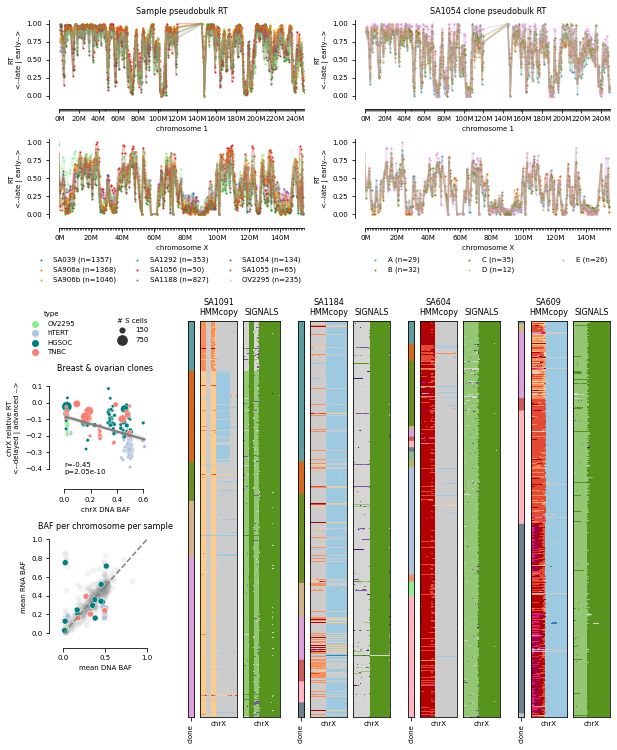

In [73]:
# create figure
fig = plt.figure(figsize=(8.5, 11))

# add four RT profiles at the top of the heatmap
ax0 = fig.add_axes([0.1, 0.88, 0.4, 0.1])
# ax0.set_title('ax0')
ax1 = fig.add_axes([0.1, 0.73, 0.4, 0.1])
# ax1.set_title('ax1')
ax2 = fig.add_axes([0.6, 0.88, 0.4, 0.1])
# ax2.set_title('ax2')
ax3 = fig.add_axes([0.6, 0.73, 0.4, 0.1])
# ax3.set_title('ax3')

# add two large subplots on the left hand side of the figure
ax4 = fig.add_axes([0.1, 0.4, 0.15, 0.13])
# ax4.set_title('ax4')
ax5 = fig.add_axes([0.1, 0.2, 0.15, 0.13])
# ax5.set_title('ax5')

# add three tall colorbars which contain the clone IDs, HMMcopy, and signals states for SA1091 G1/2-phase cells
ax6 = fig.add_axes([0.31, 0.1, 0.01, 0.5])
# ax6.set_title('ax6')
ax7 = fig.add_axes([0.33, 0.1, 0.06, 0.5])
# ax7.set_title('ax7')
ax8 = fig.add_axes([0.40, 0.1, 0.06, 0.5])
# ax8.set_title('ax8')

# repeat for SA1184
ax9 = fig.add_axes([0.49, 0.1, 0.01, 0.5])
# ax9.set_title('ax9')
ax10 = fig.add_axes([0.51, 0.1, 0.06, 0.5])
# ax10.set_title('ax10')
ax11 = fig.add_axes([0.58, 0.1, 0.06, 0.5])
# ax11.set_title('ax11')

# repeat for SA604
ax12 = fig.add_axes([0.67, 0.1, 0.01, 0.5])
# ax12.set_title('ax12')
ax13 = fig.add_axes([0.69, 0.1, 0.06, 0.5])
# ax13.set_title('ax13')
ax14 = fig.add_axes([0.76, 0.1, 0.06, 0.5])
# ax14.set_title('ax14')

# repeat for SA609
ax15 = fig.add_axes([0.85, 0.1, 0.01, 0.5])
# ax15.set_title('ax15')
ax16 = fig.add_axes([0.87, 0.1, 0.06, 0.5])
# ax16.set_title('ax16')
ax17 = fig.add_axes([0.94, 0.1, 0.06, 0.5])
# ax17.set_title('ax17')


chrom_labels_to_remove = ['13', '15', '17', '19', '20', '22']

# plot the sample RT profiles in ax0 and ax1
plot_sample_rt_profiles(rt, rt_coi, counts, ax0, ax1, chrom_labels_to_remove)

# plot the clone RT profiles for SA1054 in ax2 and ax3
plot_clone_rt_profiles(rt, 'SA1054', counts, ax2, ax3, chrom_labels_to_remove)

# plot chrX RT vs DNA BAF for each clone in the metacohort
plot_clone_chrX_rt_vs_baf(clone_df, ax4)

# plot DNA vs RNA BAF for each chromosome in each sample
plot_sample_dna_vs_rna_bafs(sample_bafs_full_chr, ax5)

# plot the HMMcopy and signals states for SA1091 G1/2-phase cells in ax6, ax7, and ax8
plot_cn_and_signals_states(
    signals_df.query('patient=="SA1091"'), ax6, ax7, ax8,
    cn_col='state', signals_col='state_phase_int', secondary_sort_col='cell_id_int',
    clone_col='clone_id', chromosome='X'
)
ax7.set_title('SA1091\nHMMcopy')
ax8.set_title('SIGNALS')

# plot the HMMcopy and signals states for SA1184 G1/2-phase cells in ax9, ax10, and ax11
plot_cn_and_signals_states(
    signals_df.query('patient=="SA1184"'), ax9, ax10, ax11,
    cn_col='state', signals_col='state_phase_int', secondary_sort_col='cell_id_int',
    clone_col='clone_id', chromosome='X'
)
ax10.set_title('SA1184\nHMMcopy')
ax11.set_title('SIGNALS')

# plot the HMMcopy and signals states for SA604 G1/2-phase cells in ax12, ax13, and ax14
plot_cn_and_signals_states(
    signals_df.query('patient=="SA604"'), ax12, ax13, ax14,
    cn_col='state', signals_col='state_phase_int', secondary_sort_col='cell_id_int',
    clone_col='clone_id', chromosome='X'
)
ax13.set_title('SA604\nHMMcopy')
ax14.set_title('SIGNALS')

# plot the HMMcopy and signals states for SA609 G1/2-phase cells in ax15, ax16, and ax17
plot_cn_and_signals_states(
    signals_df.query('patient=="SA609"'), ax15, ax16, ax17,
    cn_col='state', signals_col='state_phase_int', secondary_sort_col='cell_id_int',
    clone_col='clone_id', chromosome='X'
)
ax16.set_title('SA609\nHMMcopy')
ax17.set_title('SIGNALS')


# draw a dashed lines around the boundaries of the entire figure to know where to crop
# ax_bottom = fig.add_axes([0, 0, 1, 0.01])
# ax_top = fig.add_axes([0, 0.99, 1, 0.01])
# ax_left = fig.add_axes([0, 0, 0.01, 1])
# ax_right = fig.add_axes([0.99, 0, 0.01, 1])
# for ax in [ax_bottom, ax_top, ax_left, ax_right]:
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])

fig.savefig('scdna_replication_paper/manuscript/extended_data_figs/figED6.pdf', dpi=300, bbox_inches='tight')

plt.show()